### This code file is the final version, which includes all data processing, model construction, model training, model testing, and all graph drawing codes.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import re
import ast
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, LSTM, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_tuner import RandomSearch
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Read data
df = pd.read_csv('audio_features.csv')

In [10]:
# Define functions for parsing arrays
def parse_array(column):
    # Remove newlines and extra spaces in the array, and then use ast.literal_eval to parse
    clean_str = re.sub(r'\s+', ',', column.strip())
    clean_str = clean_str.replace('[,', '[').replace(',,', ',')
    return np.array(ast.literal_eval(clean_str))

# Apply parsing function
df['MFCCs'] = df['MFCCs'].apply(parse_array)
df['Chroma_Features'] = df['Chroma_Features'].apply(parse_array)

# Extract features and target variables
X = df.drop(columns=['C_val', 'M_val', 'D_val'])
y = df[['C_val', 'M_val', 'D_val']]

# Standardize features except MFCCs and Chroma_Features
scalar_features = X.drop(columns=['MFCCs', 'Chroma_Features'])
scaler = StandardScaler()
scalar_features_scaled = scaler.fit_transform(scalar_features)

# Convert MFCCs and Chroma_Features to arrays
mfccs = np.stack(X['MFCCs'].values)
chroma = np.stack(X['Chroma_Features'].values)

# Combined features
X_combined = np.hstack([scalar_features_scaled, mfccs, chroma])

# Divide training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Get the dimensions of each feature
num_mfccs = mfccs.shape[1]
num_spectral_features = scalar_features_scaled.shape[1]
num_chroma_features = chroma.shape[1]

# Verify data
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(436480, 35) (109120, 35)
(436480, 3) (109120, 3)


In [10]:
# Define the function to build the model
def build_model(hp):
    # define input
    input_mfccs = Input(shape=(num_mfccs, 1))
    input_spectral = Input(shape=(num_spectral_features,))
    input_chroma = Input(shape=(num_chroma_features, 1))

    # CNN model part
    x = Conv1D(filters=hp.Int('filters', min_value=16, max_value=64, step=16), 
               kernel_size=hp.Choice('kernel_size', values=[3, 5]), 
               activation='relu')(input_mfccs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)

    # RNN model part
    y = LSTM(units=hp.Int('lstm_units', min_value=32, max_value=128, step=32), 
             return_sequences=True)(input_chroma)
    y = LSTM(units=hp.Int('lstm_units_2', min_value=32, max_value=128, step=32))(y)

    # Merge CNN and RNN output
    combined = concatenate([x, input_spectral, y])

    # Fully connected layer
    z = Dense(units=hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu')(combined)
    z = Dense(units=hp.Int('dense_units_2', min_value=32, max_value=128, step=32), activation='relu')(z)
    output = Dense(3)(z)  # Output 3 parameters C, M, D

    # Build model
    model = Model(inputs=[input_mfccs, input_spectral, input_chroma], outputs=output)

    # Compile model
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), 
                  loss='mse')
    
    return model

# Use Keras Tuner’s RandomSearch for hyperparameter search
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Number of searches
    executions_per_trial=1,  # Train once for each hyperparameter combination
    directory='random_search_results',
    project_name='audio_features_optimization'
)

# Split features into different parts
mfccs_train = X_train[:, -num_mfccs - num_chroma_features: -num_chroma_features].reshape(-1, num_mfccs, 1)
spectral_train = X_train[:, :-num_mfccs - num_chroma_features]  # Assume the rest are other features
chroma_train = X_train[:, -num_chroma_features:].reshape(-1, num_chroma_features, 1)  # Adjust chroma features to three dimensions

mfccs_test = X_test[:, -num_mfccs - num_chroma_features: -num_chroma_features].reshape(-1, num_mfccs, 1)
spectral_test = X_test[:, :-num_mfccs - num_chroma_features]
chroma_test = X_test[:, -num_chroma_features:].reshape(-1, num_chroma_features, 1)

# Define callback function
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

# Perform a hyperparameter search
tuner.search(
    [mfccs_train, spectral_train, chroma_train], y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Get the hyperparameters of the best model
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Output the hyperparameters of the best model
print("Best Hyperparameters:")
print(f"Filters (CNN): {best_hyperparameters.get('filters')}")
print(f"Kernel Size (CNN): {best_hyperparameters.get('kernel_size')}")
print(f"LSTM Units (First Layer): {best_hyperparameters.get('lstm_units')}")
print(f"LSTM Units (Second Layer): {best_hyperparameters.get('lstm_units_2')}")
print(f"Dense Units (First Layer): {best_hyperparameters.get('dense_units')}")
print(f"Dense Units (Second Layer): {best_hyperparameters.get('dense_units_2')}")
print(f"Learning Rate: {best_hyperparameters.get('learning_rate')}")

Trial 10 Complete [00h 37m 58s]
val_loss: 516.4470825195312

Best val_loss So Far: 25.178808212280273
Total elapsed time: 07h 57m 36s
Best Hyperparameters:
Filters (CNN): 32
Kernel Size (CNN): 3
LSTM Units (First Layer): 96
LSTM Units (Second Layer): 64
Dense Units (First Layer): 256
Dense Units (Second Layer): 32
Learning Rate: 0.001


d:\Python\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [11]:
# Evaluate the model
y_pred = best_model.predict([mfccs_test, spectral_test, chroma_test])

# Calculate evaluation indicators
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

# Model summary
best_model.summary()

# Save the best model
best_model.save('best_model_optimized.keras')

3410/3410 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step
Mean Squared Error: 28.665155731744175
R² Score: 0.9714831137853172


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 20, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 18, 32)    │        128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 12, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 9, 32)     │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 12, 96)    │     37,632 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 288)       │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     41,216 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 355)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ input_layer_1[0]… │
│                     │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     91,136 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      8,224 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 3)         │         99 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 178,435 (697.01 KB)

 Trainable params: 178,435 (697.01 KB)

 Non-trainable params: 0 (0.00 B)

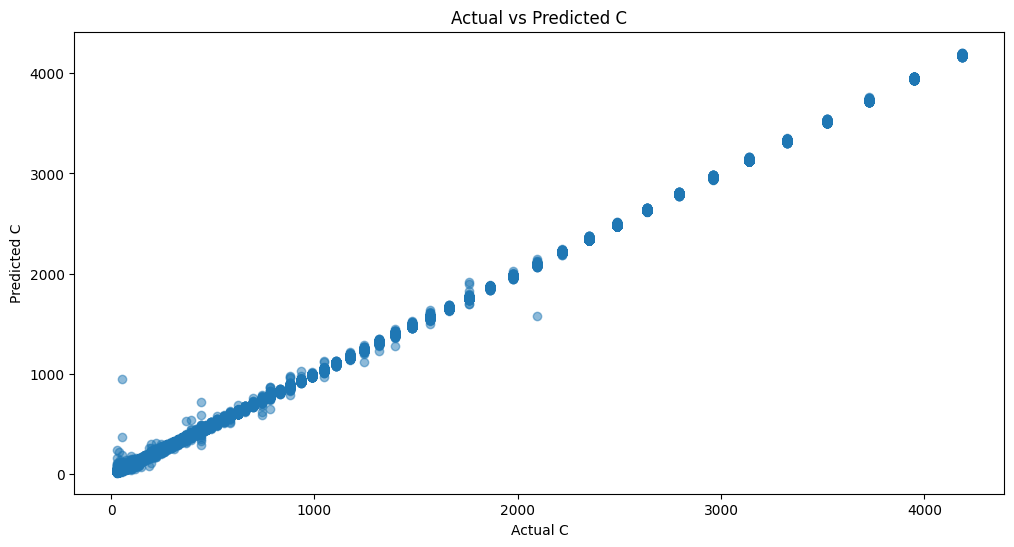

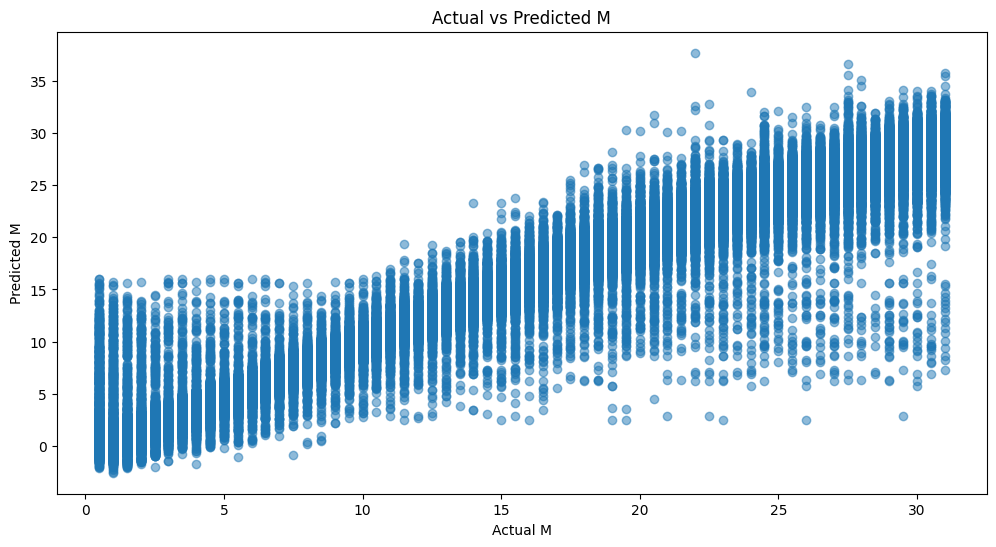

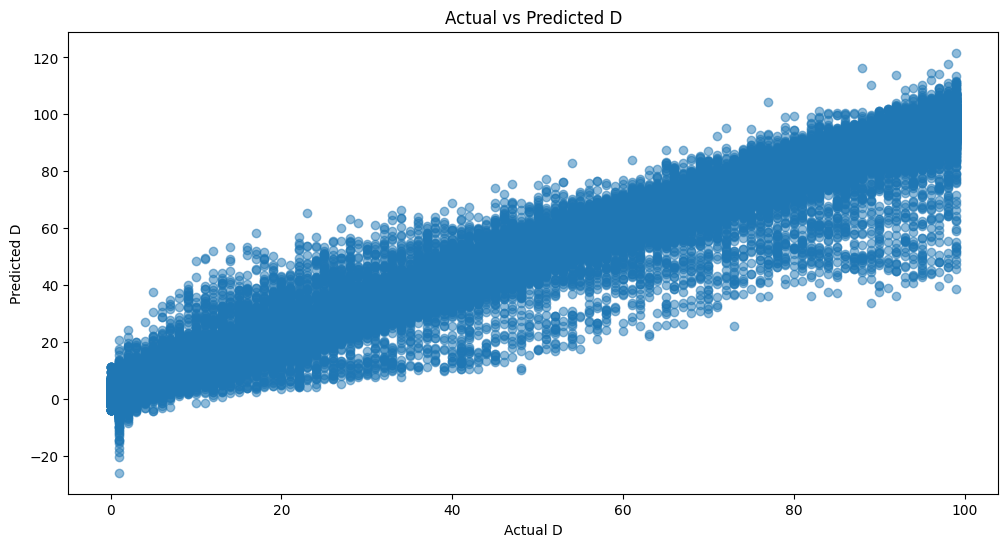

In [12]:

# Visualize prediction results
plt.figure(figsize=(12, 6))
plt.scatter(y_test['C_val'], y_pred[:, 0], alpha=0.5)
plt.xlabel('Actual C')
plt.ylabel('Predicted C')
plt.title('Actual vs Predicted C')
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(y_test['M_val'], y_pred[:, 1], alpha=0.5)
plt.xlabel('Actual M')
plt.ylabel('Predicted M')
plt.title('Actual vs Predicted M')
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(y_test['D_val'], y_pred[:, 2], alpha=0.5)
plt.xlabel('Actual D')
plt.ylabel('Predicted D')
plt.title('Actual vs Predicted D')
plt.show()

In [13]:
from keras_tuner import RandomSearch

# Reload tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='random_search_results',
    project_name='audio_features_optimization'
)

# Get all hyperparameter test results
results = tuner.oracle.get_best_trials(num_trials=10)

# Output detailed information of all experiments
for i, trial in enumerate(results):
    print(f"Trial {i+1}:")
    print(f"Filters (CNN): {trial.hyperparameters.get('filters')}")
    print(f"Kernel Size (CNN): {trial.hyperparameters.get('kernel_size')}")
    print(f"LSTM Units (First Layer): {trial.hyperparameters.get('lstm_units')}")
    print(f"LSTM Units (Second Layer): {trial.hyperparameters.get('lstm_units_2')}")
    print(f"Dense Units (First Layer): {trial.hyperparameters.get('dense_units')}")
    print(f"Dense Units (Second Layer): {trial.hyperparameters.get('dense_units_2')}")
    print(f"Learning Rate: {trial.hyperparameters.get('learning_rate')}")
    print(f"Final Loss: {trial.score}")
    print("-----")


Reloading Tuner from random_search_results\audio_features_optimization\tuner0.json
Trial 1:
Filters (CNN): 32
Kernel Size (CNN): 3
LSTM Units (First Layer): 96
LSTM Units (Second Layer): 64
Dense Units (First Layer): 256
Dense Units (Second Layer): 32
Learning Rate: 0.001
Final Loss: 25.178808212280273
-----
Trial 2:
Filters (CNN): 64
Kernel Size (CNN): 3
LSTM Units (First Layer): 96
LSTM Units (Second Layer): 64
Dense Units (First Layer): 64
Dense Units (Second Layer): 128
Learning Rate: 0.001
Final Loss: 42.62942886352539
-----
Trial 3:
Filters (CNN): 64
Kernel Size (CNN): 5
LSTM Units (First Layer): 96
LSTM Units (Second Layer): 64
Dense Units (First Layer): 64
Dense Units (Second Layer): 64
Learning Rate: 0.001
Final Loss: 42.69839096069336
-----
Trial 4:
Filters (CNN): 16
Kernel Size (CNN): 3
LSTM Units (First Layer): 96
LSTM Units (Second Layer): 96
Dense Units (First Layer): 192
Dense Units (Second Layer): 128
Learning Rate: 0.0001
Final Loss: 60.49284744262695
-----
Trial 5:
Fi

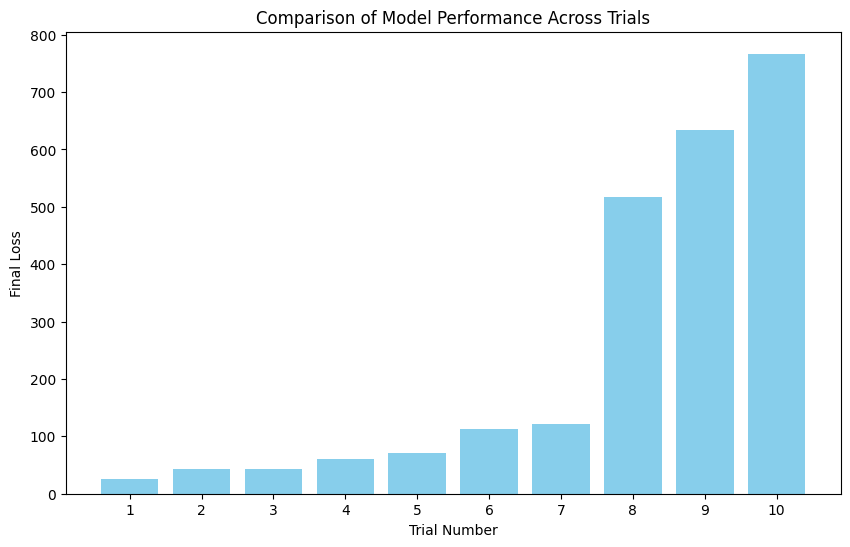

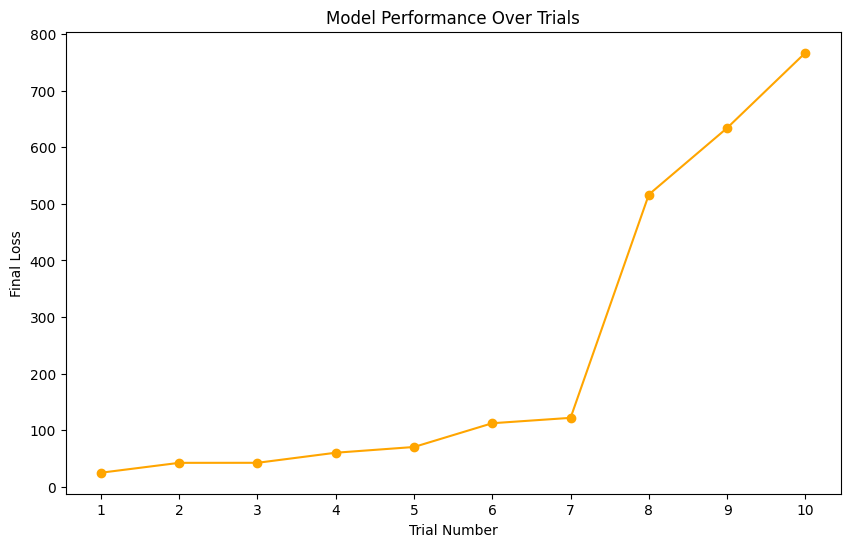

In [5]:
import matplotlib.pyplot as plt

# Organize the output results into a list
trial_numbers = list(range(1, 11))
final_losses = [
    25.1788,  # Trial 1
    42.6294,  # Trial 2
    42.6984,  # Trial 3
    60.4928,  # Trial 4
    70.6197,  # Trial 5
    112.5874, # Trial 6
    122.0829, # Trial 7
    516.4471, # Trial 8
    633.9720, # Trial 9
    766.8515  # Trial 10
]

# Draw bar chart
plt.figure(figsize=(10, 6))
plt.bar(trial_numbers, final_losses, color='skyblue')
plt.xlabel('Trial Number')
plt.ylabel('Final Loss')
plt.title('Comparison of Model Performance Across Trials')
plt.xticks(trial_numbers)  # Make sure the number of each trial is displayed on the X-axis
plt.show()

# Draw a line chart
plt.figure(figsize=(10, 6))
plt.plot(trial_numbers, final_losses, marker='o', linestyle='-', color='orange')
plt.xlabel('Trial Number')
plt.ylabel('Final Loss')
plt.title('Model Performance Over Trials')
plt.xticks(trial_numbers)  # Make sure the number of each trial is displayed on the X-axis
plt.show()


1964/1964 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
Mean Squared Error on new data: 244.4264145648303
R² Score on new data: 0.9036408623099983


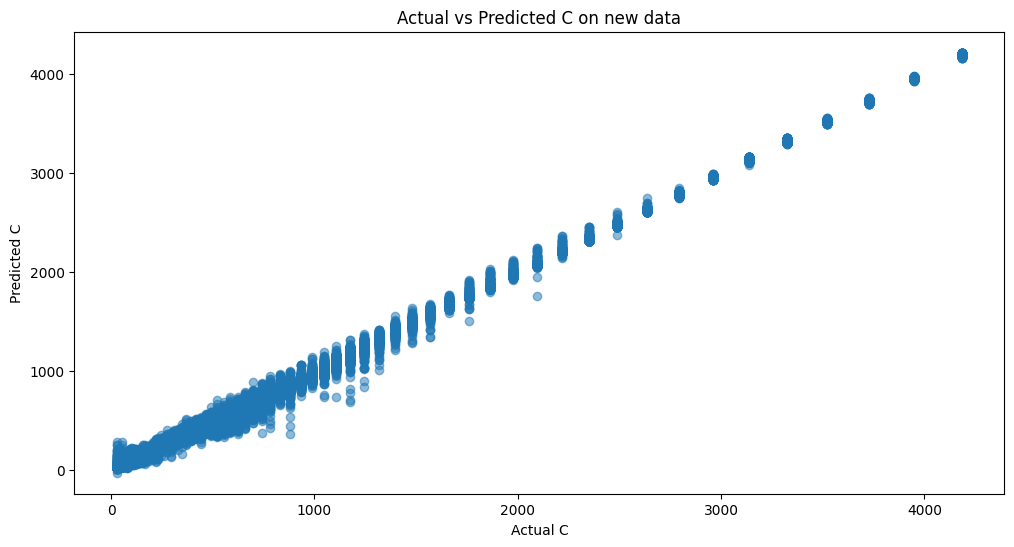

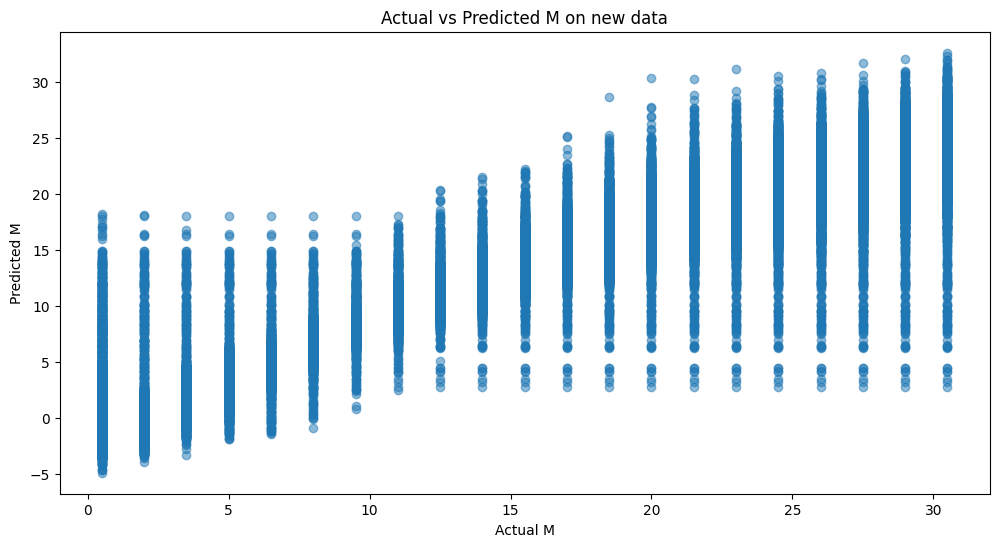

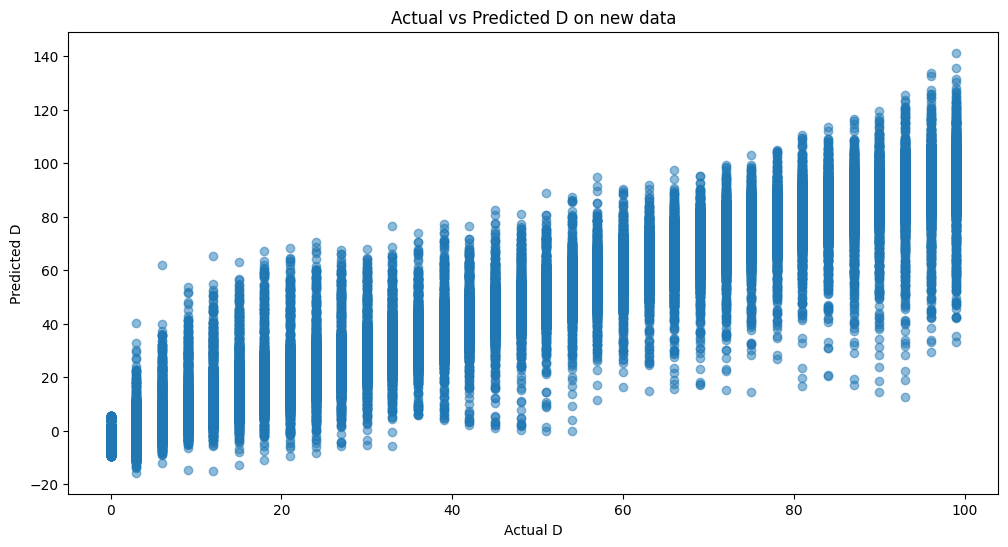

In [13]:
import tensorflow as tf
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load the best saved model
best_model = tf.keras.models.load_model('best_model_optimized.keras', compile=False)
# Read new data
new_df = pd.read_csv('audio_features_test.csv')

# Apply previous parsing and preprocessing functions
new_df['MFCCs'] = new_df['MFCCs'].apply(parse_array)
new_df['Chroma_Features'] = new_df['Chroma_Features'].apply(parse_array)

# Extract features and target variables
X_new = new_df.drop(columns=['C_val', 'M_val', 'D_val'])
y_new = new_df[['C_val', 'M_val', 'D_val']]

# Standardize features except MFCCs and Chroma_Features
scalar_features_new = X_new.drop(columns=['MFCCs', 'Chroma_Features'])
scalar_features_scaled_new = scaler.transform(scalar_features_new)

# Convert MFCCs and Chroma_Features to arrays
mfccs_new = np.stack(X_new['MFCCs'].values)
chroma_new = np.stack(X_new['Chroma_Features'].values)

# Combined features
X_combined_new = np.hstack([scalar_features_scaled_new, mfccs_new, chroma_new])

# Split the features of the new dataset into different parts
mfccs_new_test = X_combined_new[:, -num_mfccs - num_chroma_features: -num_chroma_features].reshape(-1, num_mfccs, 1)
spectral_new_test = X_combined_new[:, :-num_mfccs - num_chroma_features]
chroma_new_test = X_combined_new[:, -num_chroma_features:].reshape(-1, num_chroma_features, 1)

# Evaluate the performance of the model on the new data set
y_pred_new = best_model.predict([mfccs_new_test, spectral_new_test, chroma_new_test])

# Calculate evaluation indicators
mse_new = mean_squared_error(y_new, y_pred_new)
r2_new = r2_score(y_new, y_pred_new)

print(f'Mean Squared Error on new data: {mse_new}')
print(f'R² Score on new data: {r2_new}')


# Visualize prediction results
plt.figure(figsize=(12, 6))
plt.scatter(y_new['C_val'], y_pred_new[:, 0], alpha=0.5)
plt.xlabel('Actual C')
plt.ylabel('Predicted C')
plt.title('Actual vs Predicted C on new data')
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(y_new['M_val'], y_pred_new[:, 1], alpha=0.5)
plt.xlabel('Actual M')
plt.ylabel('Predicted M')
plt.title('Actual vs Predicted M on new data')
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(y_new['D_val'], y_pred_new[:, 2], alpha=0.5)
plt.xlabel('Actual D')
plt.ylabel('Predicted D')
plt.title('Actual vs Predicted D on new data')
plt.show()



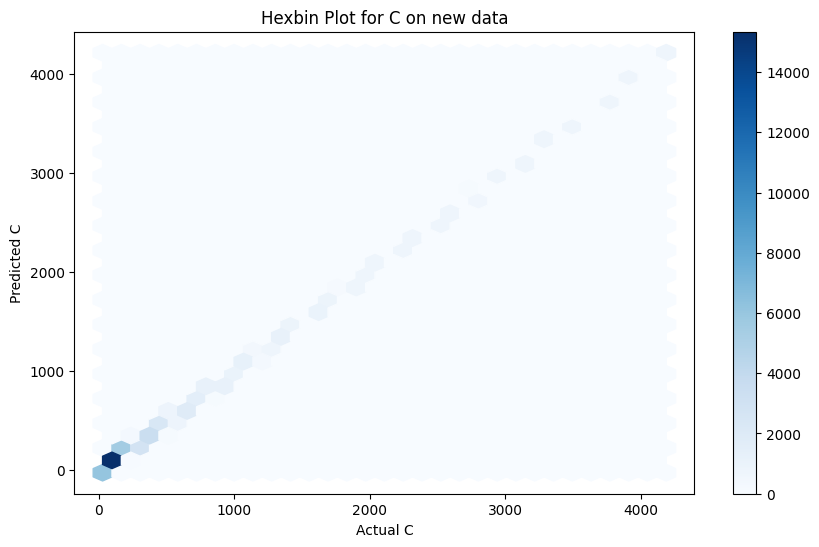

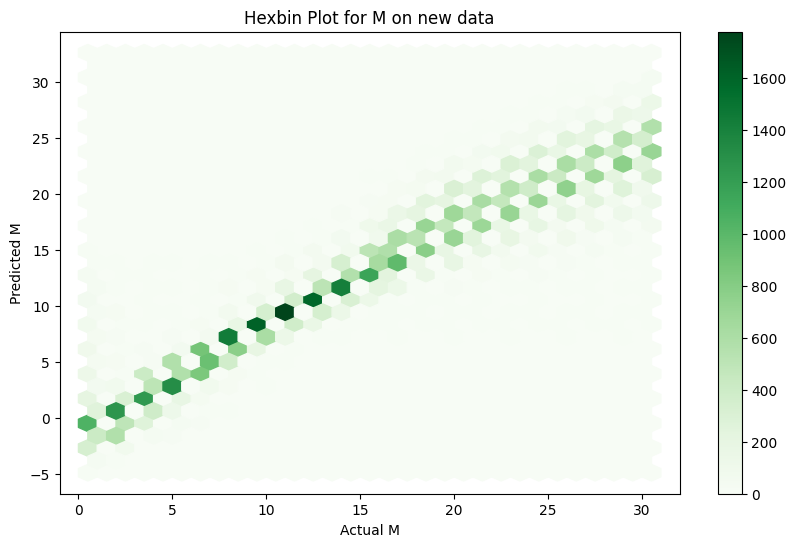

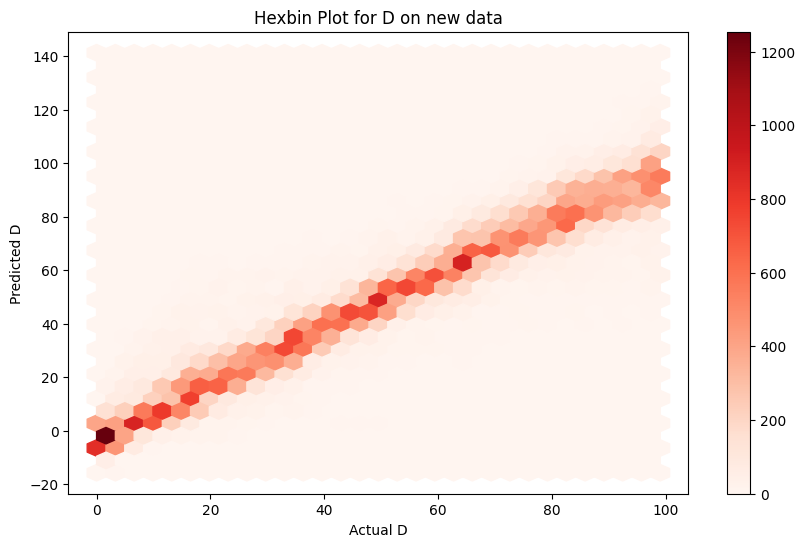

In [27]:
# Hexbin (C)
plt.figure(figsize=(10, 6))
plt.hexbin(y_new['C_val'], y_pred_new[:, 0], gridsize=30, cmap='Blues')
plt.colorbar()
plt.xlabel('Actual C')
plt.ylabel('Predicted C')
plt.title('Hexbin Plot for C on new data')
plt.show()

# Hexbin (M)
plt.figure(figsize=(10, 6))
plt.hexbin(y_new['M_val'], y_pred_new[:, 1], gridsize=30, cmap='Greens')
plt.colorbar()
plt.xlabel('Actual M')
plt.ylabel('Predicted M')
plt.title('Hexbin Plot for M on new data')
plt.show()

# Hexbin (D)
plt.figure(figsize=(10, 6))
plt.hexbin(y_new['D_val'], y_pred_new[:, 2], gridsize=30, cmap='Reds')
plt.colorbar()
plt.xlabel('Actual D')
plt.ylabel('Predicted D')
plt.title('Hexbin Plot for D on new data')
plt.show()

1964/1964 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
Mean Squared Error on new data: 199.9884799910683
R² Score on new data: 0.8861805368063619


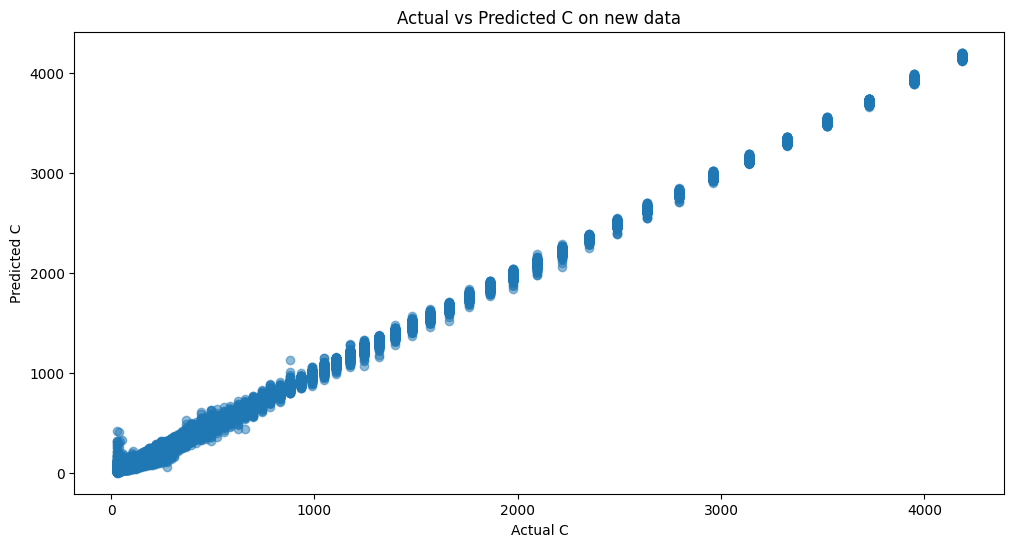

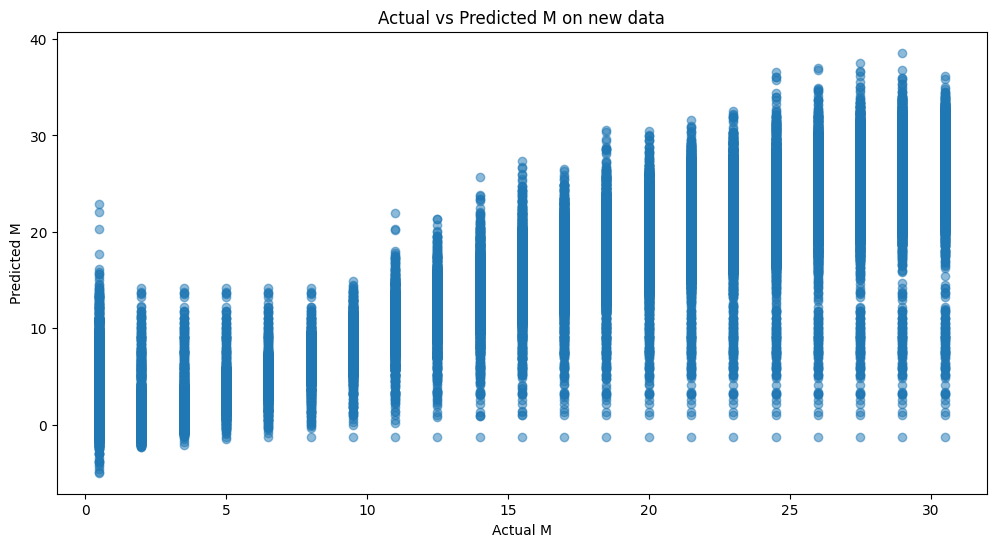

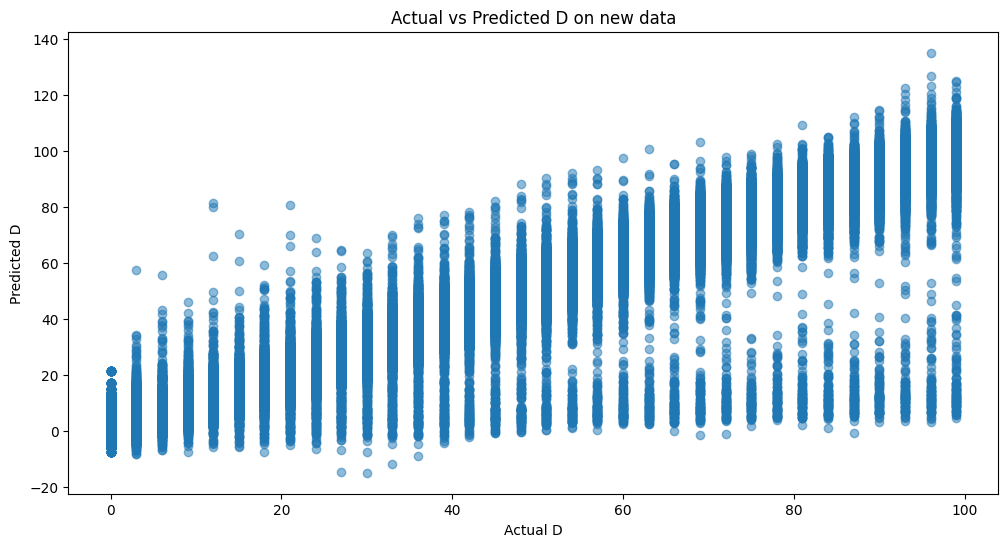

In [15]:
# Read new data
new2_df = pd.read_csv('audio_features_test2.csv')

# Apply previous parsing and preprocessing functions
new2_df['MFCCs'] = new2_df['MFCCs'].apply(parse_array)
new2_df['Chroma_Features'] = new2_df['Chroma_Features'].apply(parse_array)

# Extract features and target variables
X_new2 = new2_df.drop(columns=['C_val', 'M_val', 'D_val'])
y_new2 = new2_df[['C_val', 'M_val', 'D_val']]

# Standardize features except MFCCs and Chroma_Features
scalar_features_new2 = X_new2.drop(columns=['MFCCs', 'Chroma_Features'])
scalar_features_scaled_new2 = scaler.transform(scalar_features_new2)

# Convert MFCCs and Chroma_Features to arrays
mfccs_new2 = np.stack(X_new2['MFCCs'].values)
chroma_new2 = np.stack(X_new2['Chroma_Features'].values)

# Combined features
X_combined_new2 = np.hstack([scalar_features_scaled_new2, mfccs_new2, chroma_new2])

# Split the features of the new dataset into different parts
mfccs_new2_test = X_combined_new2[:, -num_mfccs - num_chroma_features: -num_chroma_features].reshape(-1, num_mfccs, 1)
spectral_new2_test = X_combined_new2[:, :-num_mfccs - num_chroma_features]
chroma_new2_test = X_combined_new2[:, -num_chroma_features:].reshape(-1, num_chroma_features, 1)

# Evaluate the performance of the model on the new data set
y_pred_new2 = best_model.predict([mfccs_new2_test, spectral_new2_test, chroma_new2_test])

# Calculate evaluation indicators
mse_new2 = mean_squared_error(y_new2, y_pred_new2)
r2_new2 = r2_score(y_new2, y_pred_new2)

print(f'Mean Squared Error on new data: {mse_new2}')
print(f'R² Score on new data: {r2_new2}')

# Visualize prediction results
plt.figure(figsize=(12, 6))
plt.scatter(y_new2['C_val'], y_pred_new2[:, 0], alpha=0.5)
plt.xlabel('Actual C')
plt.ylabel('Predicted C')
plt.title('Actual vs Predicted C on new data')
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(y_new2['M_val'], y_pred_new2[:, 1], alpha=0.5)
plt.xlabel('Actual M')
plt.ylabel('Predicted M')
plt.title('Actual vs Predicted M on new data')
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(y_new2['D_val'], y_pred_new2[:, 2], alpha=0.5)
plt.xlabel('Actual D')
plt.ylabel('Predicted D')
plt.title('Actual vs Predicted D on new data')
plt.show()

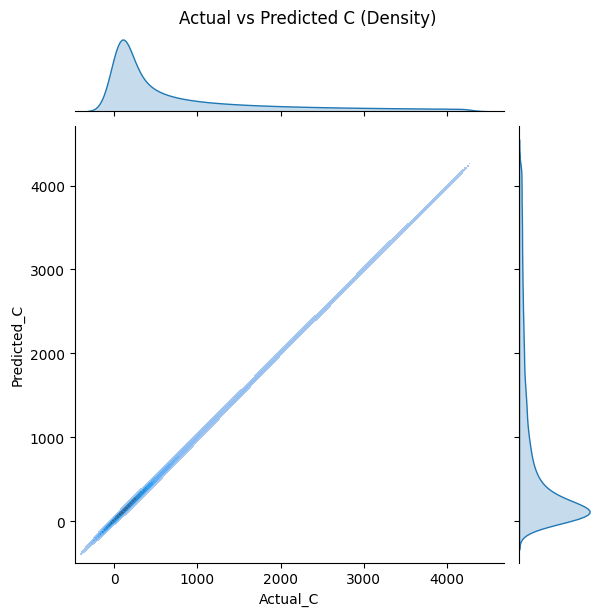

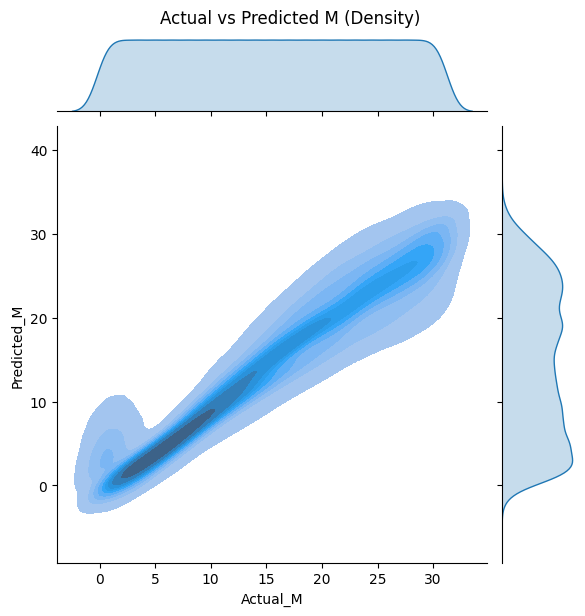

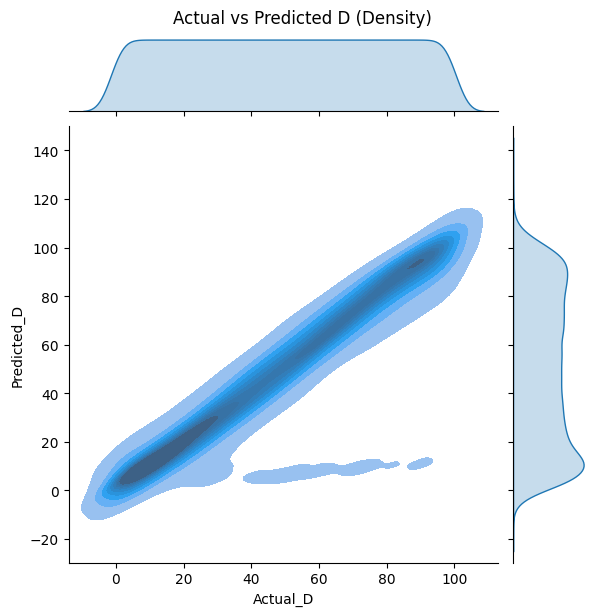

In [18]:
import seaborn as sns
import pandas as pd

# Combine actual values ​​and predicted values ​​into a DataFrame
results_df_new2 = pd.DataFrame({
    'Actual_C': y_new2['C_val'],
    'Predicted_C': y_pred_new2[:, 0],
    'Actual_M': y_new2['M_val'],
    'Predicted_M': y_pred_new2[:, 1],
    'Actual_D': y_new2['D_val'],
    'Predicted_D': y_pred_new2[:, 2]
})

# Diagonal density plot (C)
sns.jointplot(x='Actual_C', y='Predicted_C', data=results_df_new2, kind='kde', fill=True)
plt.suptitle('Actual vs Predicted C (Density)', y=1.02)
plt.show()

# Diagonal density plot (M)
sns.jointplot(x='Actual_M', y='Predicted_M', data=results_df_new2, kind='kde', fill=True)
plt.suptitle('Actual vs Predicted M (Density)', y=1.02)
plt.show()

# Diagonal density plot (D)
sns.jointplot(x='Actual_D', y='Predicted_D', data=results_df_new2, kind='kde', fill=True)
plt.suptitle('Actual vs Predicted D (Density)', y=1.02)
plt.show()


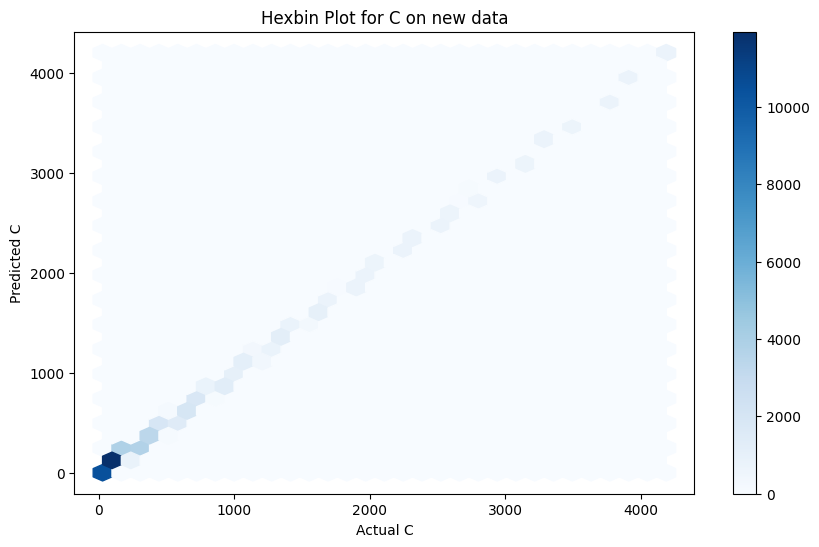

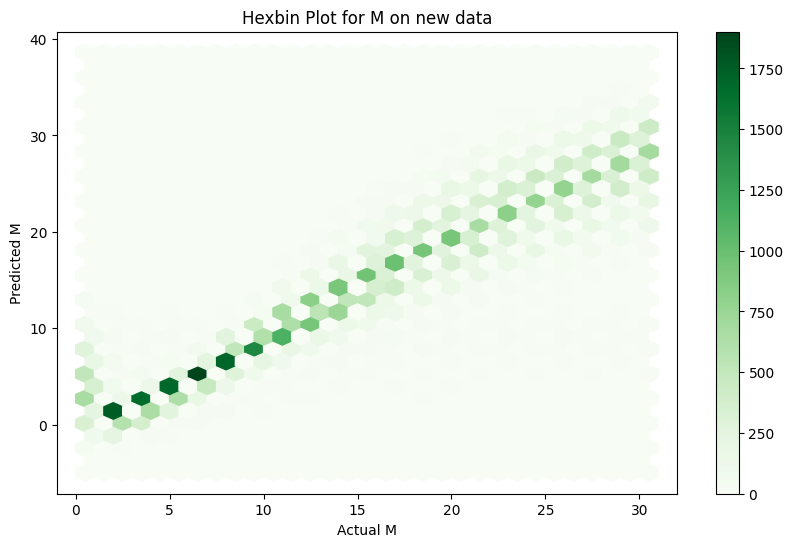

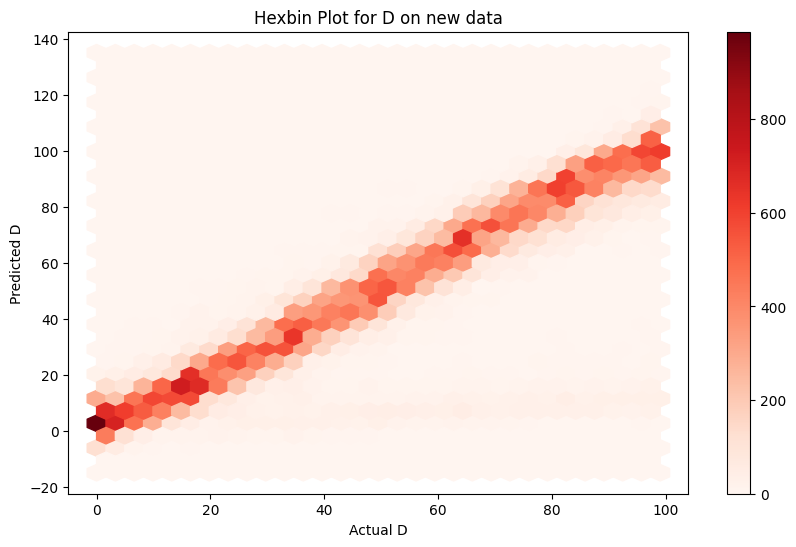

In [26]:
# Hexbin (C)
plt.figure(figsize=(10, 6))
plt.hexbin(y_new2['C_val'], y_pred_new2[:, 0], gridsize=30, cmap='Blues')
plt.colorbar()
plt.xlabel('Actual C')
plt.ylabel('Predicted C')
plt.title('Hexbin Plot for C on new data')
plt.show()

# Hexbin (M)
plt.figure(figsize=(10, 6))
plt.hexbin(y_new2['M_val'], y_pred_new2[:, 1], gridsize=30, cmap='Greens')
plt.colorbar()
plt.xlabel('Actual M')
plt.ylabel('Predicted M')
plt.title('Hexbin Plot for M on new data')
plt.show()

# Hexbin (D)
plt.figure(figsize=(10, 6))
plt.hexbin(y_new2['D_val'], y_pred_new2[:, 2], gridsize=30, cmap='Reds')
plt.colorbar()
plt.xlabel('Actual D')
plt.ylabel('Predicted D')
plt.title('Hexbin Plot for D on new data')
plt.show()
